In [8]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

# MNISTデータセットのロード
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.reshape(x_train, (x_train.shape[0], 28, 28, 1))
x_test = np.reshape(x_test, (x_test.shape[0], 28, 28, 1))

# データサンプリング
sample_size = x_train.shape[0]
x_train = x_train[:sample_size]
y_train = y_train[:sample_size]

# VAEのモデル定義
latent_dim = 2  # 潜在空間の次元数

def build_vae(latent_dim):
    # エンコーダー
    encoder_inputs = layers.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(encoder_inputs)
    x = layers.MaxPooling2D(padding='same')(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation='relu')(x)
    
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)
    
    def sampling(args):
        z_mean, z_log_var = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = layers.Lambda(sampling)([z_mean, z_log_var])

    # デコーダー
    latent_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(7 * 7 * 64, activation='relu')(latent_inputs)
    x = layers.Reshape((7, 7, 64))(x)
    x = layers.Conv2DTranspose(64, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D()(x)
    x = layers.Conv2DTranspose(32, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D()(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)

    encoder = models.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    decoder = models.Model(latent_inputs, decoder_outputs, name="decoder")

    vae_outputs = decoder(encoder(encoder_inputs)[2])
    vae = models.Model(encoder_inputs, vae_outputs, name="vae")

    return vae, encoder, decoder

vae, encoder, decoder = build_vae(latent_dim)
vae.compile(optimizer='adam', loss='binary_crossentropy')

In [9]:
# VAEの訓練
vae.fit(x_train, x_train, epochs=10, batch_size=128)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 52s 107ms/step - loss: 0.2997
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 49s 104ms/step - loss: 0.2044
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 47s 99ms/step - loss: 0.1964
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 47s 100ms/step - loss: 0.1925
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 47s 100ms/step - loss: 0.1903
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 47s 100ms/step - loss: 0.1877
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 47s 99ms/step - loss: 0.1864
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 47s 99ms/step - loss: 0.1853
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 48s 102ms/step - loss: 0.1845
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 48s 102ms/step - loss: 0.1833


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


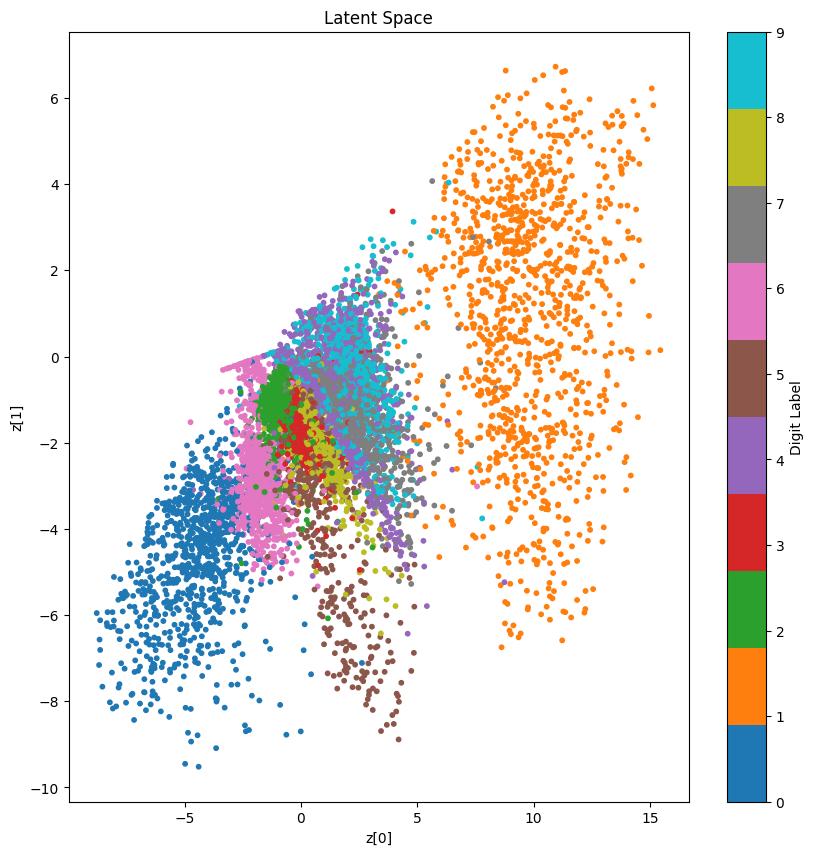

In [13]:
# 潜在空間のプロット
def plot_latent_space(encoder, x_test, y_test, figsize=(10, 10)):
    z_mean, _, _ = encoder.predict(x_test, batch_size=128)
    plt.figure(figsize=figsize)
    scatter = plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test, cmap='tab10', s=10)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.title("Latent Space")
    plt.colorbar(scatter, label='Digit Label')
    plt.show()

plot_latent_space(encoder, x_test[:sample_size], y_test[:sample_size])

In [61]:
def generate_latent_space_images(decoder, grid_size=10, min_val=-4.0, max_val=4.0):
    # 潜在空間のグリッドを作成
    grid_x = np.linspace(min_val, max_val, grid_size)
    grid_y = np.linspace(min_val, max_val, grid_size)
    grid_x, grid_y = np.meshgrid(grid_x, grid_y)
    
    # グリッドの座標をフラット化
    latent_samples = np.vstack([grid_x.ravel(), grid_y.ravel()]).T
    
    # デコーダーを使って画像を生成
    generated_images = decoder.predict(latent_samples)
    
    # 画像サイズの取得
    image_height, image_width = generated_images.shape[1:3]
    
    # グリッド上に画像を並べる
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(grid_size * image_width / 100, grid_size * image_height / 100), dpi=100)
    
    # 画像の間隔を0にする
    plt.subplots_adjust(wspace=0, hspace=0)
    
    axs = axs.flatten()
    for img, ax in zip(generated_images, axs):
        ax.imshow(img.squeeze(), cmap='gray')
        ax.axis('off')
    
    # グリッドの背景色を透明にする
    fig.patch.set_visible(False)
    plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


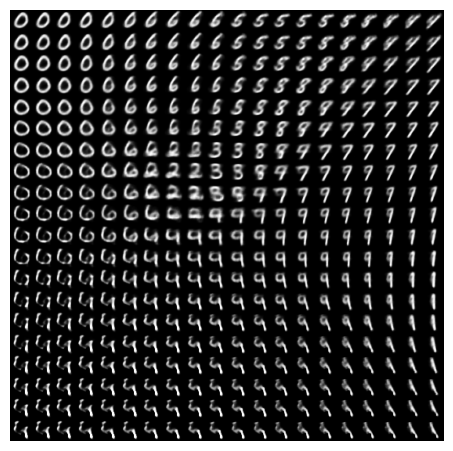

In [71]:
# 潜在空間の最大値と最小値に基づいて画像を生成
min_val = -5
max_val = 5
generate_latent_space_images(decoder, grid_size=20, min_val=min_val, max_val=max_val)

In [66]:
# 潜在空間の最大値を計算する関数
def calculate_latent_space_max(decoder, num_samples=10000):
    # 潜在空間からサンプルを生成
    latent_samples = np.random.normal(size=(num_samples, latent_dim))
    
    # デコーダーを使って画像を生成
    generated_images = decoder.predict(latent_samples)
    
    # 潜在空間の最大値を計算
    max_latent_values = np.max(latent_samples, axis=0)
    min_latent_values = np.min(latent_samples, axis=0)
    
    return max_latent_values, min_latent_values
# 潜在空間の最大値を計算
max_latent, min_latent = calculate_latent_space_max(decoder)
print("Latent Space Max Values:", max_latent)
print("Latent Space Min Values:", min_latent)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Latent Space Max Values: [3.72975981 3.6993694 ]
Latent Space Min Values: [-3.66023794 -4.53950604]
